In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

# converts from homogeneous to inhomogeneous coordinates
def Pi(ph):
    return ph[:-1]/ph[-1]
    
# converts from inhomogeneous to homogeneous coordinates
def PiInv(p):
    ones = np.ones((1, p.shape[1]))
    ph = np.vstack((p, ones))
    return ph

def projectpoints(K, R, t, Q):
    Q_homogeneous = PiInv(Q)
    q = np.hstack((R,t)) @ Q_homogeneous
    P = Pi(q)
    p = K @ PiInv(P)
    return p

def CrossOp(p):
    return np.array([[0, -p[2], p[1]],
                     [p[2], 0, -p[0]],
                     [-p[1], p[0], 0]])

def normalized2D(points):
    # Compute the mean and standard deviation of the points
    mean = np.mean(points, axis=1)
    std = np.std(points, axis=1)
    
    # Compute the transformation matrix
    T = np.array([[1/std[0], 0, -mean[0]/std[0]],
                  [0, 1/std[1], -mean[1]/std[1]],
                  [0, 0, 1]])
    
    # Normalize the points using the transformation matrix
    points_hom = PiInv(points)
    points_norm_hom = T @ points_hom
    points_norm = points_norm_hom[:2, :]
    
    return T, points_norm   

def hest(q1, q2, normalize=False):
    if normalize:
        T1, q1 = normalized2D(q1)
        T2, q2 = normalized2D(q2)
    else:
        T1 = np.eye(3)
        T2 = np.eye(3)

    q1 = PiInv(q1)
    q2 = PiInv(q2)
    B= np.kron(q2[:,0],CrossOp(q1[:,0]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i],CrossOp(q1[:,i]))
        B = np.vstack((B,B_temp))

    _,_,vh = np.linalg.svd(B.T@B)
    H = np.reshape(vh[-1],(3,3))
    H = H.T.round(2)

    H = np.linalg.inv(T2) @ H @ T1

    return H

# Exercise 4
## Mathematical exercises: Direct linear transform (DLT)
In this section consider the 3D points: 
$$
Q_{ijk} = \begin{bmatrix} i \\ j \\ k \end{bmatrix}
$$
where $i \in $ {0, 1}, $j \in $ {0, 1}, and $k \in $ {0, 1}. Consider also a camera with $f$ = 1000 and a resolution of 1920 $\times$ 1080. Furthermore, the camera is transformed such that
$$
R = \begin{bmatrix} \sqrt{1/2} & -\sqrt{1/2} & 0 \\ \sqrt{1/2} & \sqrt{1/2} & 0 \\ 0 & 0 & 1 \end{bmatrix}
$$

### Exercise 4.1
Find the projection matrix $P$ and the projections $q$.

In [21]:
K = np.array([[1000, 0, 960],
              [0, 1000, 540],
              [0, 0, 1]])

R = np.array([[np.sqrt(1/2), -np.sqrt(1/2), 0],
              [np.sqrt(1/2), np.sqrt(1/2), 0],
              [0, 0, 1]])
t = np.array([[0, 0, 10]]).T

Q = np.array([
    [0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 1, 1, 0, 0, 1, 1],
    [0, 1, 0, 1, 0, 1, 0, 1],
    np.ones(8)])    
P = K @ np.hstack((R,t))
print("Projection P = :\n", P)
q = P @ Q
q = Pi(q)
print("projects q = : \n", q.round(2))


Projection P = :
 [[ 7.07106781e+02 -7.07106781e+02  9.60000000e+02  9.60000000e+03]
 [ 7.07106781e+02  7.07106781e+02  5.40000000e+02  5.40000000e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+01]]
projects q = : 
 [[ 960.    960.    889.29  895.72 1030.71 1024.28  960.    960.  ]
 [ 540.    540.    610.71  604.28  610.71  604.28  681.42  668.56]]


### Exercise 4.2

## Programming exercise: Checkboard calibration
### Exercise 4.3

In [22]:
def checkerboard_points(n, m):
    points = []
    for i in range(n):
        for j in range(m):
            x = i - (n-1)/2
            y = j - (m-1)/2
            z = 0
            points.append([x, y, z])
    return np.array(points).T

### Exercise 4.4

In [23]:
from scipy.spatial.transform import Rotation

def R_rotation(theta_x, theta_y, theta_z):
    R = Rotation.from_euler('xyz', [theta_x, theta_y, theta_z]).as_matrix()
    return R

Q_Omega = checkerboard_points(10,20)
R_a = R_rotation(np.pi/10, 0, 0)
R_b = R_rotation(0, 0, 0)
R_c = R_rotation(-np.pi/10, 0, 0)

q_a = R_a @ Q_Omega
q_b = R_b @ Q_Omega
q_c = R_c @ Q_Omega

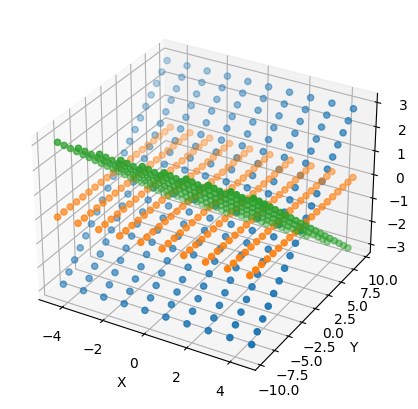

In [24]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(q_a[0,:], q_a[1,:], q_a[2,:])
ax.scatter(q_b[0,:], q_b[1,:], q_b[2,:])
ax.scatter(q_c[0,:], q_c[1,:], q_c[2,:])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Exercise 4.5

In [25]:
qs = [q_a, q_b, q_c]
def estimateHomographies(Q_omega, qs):
    homographies = []
    Q_tilde = Q_omega[:2, :]
    for q in qs:
        H = hest(Q_tilde, q[:2, :], normalize=True)
        homographies.append(H)
        
    return homographies

estimated_homographies = estimateHomographies(Q_Omega, qs)

# Check the estimated homographies
for i, H in enumerate(estimated_homographies):
    Q_tilde = PiInv(Q_Omega[:2, :])
    q_estimated_homogeneous = H @ Q_tilde
    q_estimated = Pi(q_estimated_homogeneous) 
    q_original = qs[i][:2, :]
    
    error = np.sum((q_estimated - q_original)**2)
    print(f'Error for view {i+1}: {error}')

Error for view 1: 8.289202480642663e-29
Error for view 2: 0.0
Error for view 3: 8.289202480642663e-29


### Exercise 4.6

In [26]:
def Vector_v(H,i,j):
    i = i - 1
    j = j - 1
    return np.array([H[0][i]*H[0][j], H[0][i]*H[1][j] + H[1][i]*H[0][j], 
                     H[1][i]*H[1][j], H[2][i]*H[0][j] + H[0][i]*H[2][j], 
                     H[2][i]*H[1][j] + H[1][i]*H[2][j], H[2][i]*H[2][j]])

def estimate_b(Hs):
    V = np.empty((0, 6))
    for H in Hs:
        v_12 = Vector_v(H, 1, 2)
        v_11 = Vector_v(H, 1, 1)
        v_22 = Vector_v(H, 2, 2)
        
        V_temp = np.vstack((v_12, v_11 - v_22))
        V = np.vstack((V, V_temp))
    
    _, _, vh = np.linalg.svd(V)
    b = vh[-1]
    
    return b



In [27]:
# Test the function with the homographies from the previous exercise
b_estimated = estimate_b(estimated_homographies)
print(f"b_estimated: {b_estimated}")

B_true = np.linalg.inv(K.T) @ np.linalg.inv(K)
b_true = np.array([
    B_true[0, 0],
    B_true[0, 1],
    B_true[1, 1],
    B_true[0, 2],
    B_true[1, 2],
    B_true[2, 2]
])

print(f"b_true: {b_true}")

# Check if b is a scaled version of b_true
scale_factor = b_estimated[0] / b_true[0]
print(f"Scale factor: {scale_factor}")
print(f"b_true * scale_factor: {b_true * scale_factor}")

# Debugging suggestion
h1 = estimated_homographies[0][:, 0]
h2 = estimated_homographies[0][:, 1]
v_11 = Vector_v(estimated_homographies[0], 1, 1)
print(f"v_11 @ b_true: {v_11 @ b_true}")
print(f"h1.T @ B_true @ h1: {h1.T @ B_true @ h1}")


b_estimated: [0. 0. 0. 1. 0. 0.]
b_true: [ 1.0000e-06  0.0000e+00  1.0000e-06 -9.6000e-04 -5.4000e-04  2.2132e+00]
Scale factor: 0.0
b_true * scale_factor: [ 0.  0.  0. -0. -0.  0.]
v_11 @ b_true: 3.3639999999999997e-07
h1.T @ B_true @ h1: 3.3639999999999997e-07


### Exercise 4.7

K_estimated:
[[nan nan nan]
 [ 0. nan nan]
 [ 0.  0.  1.]]
K_original:
[[1000    0  960]
 [   0 1000  540]
 [   0    0    1]]
Error between K_estimated and K_original: nan


C:\Users\lcc04\AppData\Local\Temp\ipykernel_13052\1424032372.py:17: RuntimeWarning: invalid value encountered in double_scalars
  v_0 = (b[1]*b[3] - b[0]*b[4]) / (b[0]*b[2] - b[1]**2)
